In [ ]:
# import requests
# import os
# from dotenv import load_dotenv
# import pandas as pd
# import numpy as np



In [ ]:
# #Fetching movie IDs

# load_dotenv(".env")

# api_key = os.getenv("API_KEY")
# if not api_key:
#     raise ValueError("API_KEY not found. Did you set it in .env?")

# movie_ids = [
#     0, 299534, 19995, 140607, 299536, 597, 135397, 420818,
#     24428, 168259, 99861, 284054, 12445, 181808, 330457,
#     351286, 109445, 321612, 260513
# ]

# wantedMovies = []

# for movie_id in movie_ids:     
#     if movie_id == 0:
#         continue

#     url = f"https://api.themoviedb.org/3/movie/{movie_id}?append_to_response=credits&api_key={api_key}"
    
#     response = requests.get(url)

#     if response.status_code == 200:
#         wantedMovies.append(response.json())   
#     else:
#         print(f"Failed to fetch movie {movie_id}: {response.status_code}")


In [58]:
# 1 Import functions
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.extract import fetch_movies
from src.transform import transform_movies

# 2️ Extract raw data
wanted_movies = fetch_movies()  # returns list of movie JSONs

# 3️ Transform into DataFrame
wanted_data = transform_movies(wanted_movies)  # returns pandas DataFrame

# # 4️ Inspect
# wanted_data.columns


In [59]:
# wanted_data = pd.DataFrame(wanted_movies)
wanted_data['id']


0     299534
1      19995
2     140607
3     299536
4        597
5     135397
6     420818
7      24428
8     168259
9      99861
10    284054
11     12445
12    181808
13    330457
14    351286
15    109445
16    321612
17    260513
Name: id, dtype: int64

In [60]:
wanted_data.columns

Index(['id', 'title', 'tagline', 'release_date', 'genres',
       'belongs_to_collection', 'original_language', 'budget_musd',
       'revenue_musd', 'production_companies', 'production_countries',
       'vote_count', 'vote_average', 'popularity', 'runtime', 'overview',
       'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director',
       'crew_size'],
      dtype='object')

In [ ]:
# #STEP 2:1 Dropping irrelevant columns
# wanted_data.drop(['adult', 'imdb_id', 'original_title', 'video', 'homepage'] ,axis=1, inplace=True)
# wanted_data.columns

Index(['backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'vote_average', 'vote_count', 'credits'],
      dtype='object')

In [ ]:
# #2:2  Evaluating JSON-like columns
# json_columns = [
#     'belongs_to_collection', 'genres', 'production_companies', 'spoken_languages', 'credits']

# for column in json_columns:
#     column_type = type(wanted_data[column].iloc[0])
#     print(f"{column}: {column_type}")


belongs_to_collection: <class 'dict'>
genres: <class 'list'>
production_companies: <class 'list'>
spoken_languages: <class 'list'>
credits: <class 'dict'>


In [ ]:
# wanted_data['credits']

KeyError: 'credits'

In [9]:


def extract_credits(row):
    if not isinstance(row, dict):
        row = {}

    
    cast = row.get('cast') if isinstance(row.get('cast'), list) else []
    crew = row.get('crew') if isinstance(row.get('crew'), list) else []

    
    director = None
    for person in crew:
        if isinstance(person, dict) and person.get('job') == 'Director':
            director = person.get('name')
            break

    return pd.Series({'cast': cast,'cast_size': len(cast),'director': director,'crew_size': len(crew) })


extracted_df = wanted_data['credits'].apply(extract_credits)


wanted_data = pd.concat([wanted_data.reset_index(drop=True), extracted_df.reset_index(drop=True)], axis=1)


In [62]:
wanted_data['crew_size']

0     607
1     990
2     262
3     733
4     262
5     426
6      48
7     641
8     227
9     652
10    567
11    159
12    218
13     41
14    384
15    285
16    158
17    260
Name: crew_size, dtype: int64

In [63]:
wanted_data.columns

Index(['id', 'title', 'tagline', 'release_date', 'genres',
       'belongs_to_collection', 'original_language', 'budget_musd',
       'revenue_musd', 'production_companies', 'production_countries',
       'vote_count', 'vote_average', 'popularity', 'runtime', 'overview',
       'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director',
       'crew_size'],
      dtype='object')

In [64]:
#2:3 Extracting and cleaning data points
# extracted_columns = ['belongs_to_collection','genres','spoken_languages','production_countries','production_companies', 'credits']

# for column in extracted_columns:
#     if column == 'belongs_to_collection':

#         wanted_data[column] = wanted_data[column].apply(lambda x: x['name'] if isinstance(x, dict) else None)
    
#     else:
#         wanted_data[column] = wanted_data[column].apply(  lambda x: "|".join([item['name'] for item in x]) if isinstance(x, list) else None )


wanted_data['genres']

0              Adventure|Science Fiction|Action
1      Action|Adventure|Fantasy|Science Fiction
2              Adventure|Action|Science Fiction
3              Adventure|Action|Science Fiction
4                                 Drama|Romance
5     Action|Adventure|Science Fiction|Thriller
6              Adventure|Drama|Family|Animation
7              Science Fiction|Action|Adventure
8                         Action|Crime|Thriller
9              Action|Adventure|Science Fiction
10             Action|Adventure|Science Fiction
11                            Adventure|Fantasy
12             Adventure|Action|Science Fiction
13    Family|Animation|Adventure|Comedy|Fantasy
14    Action|Adventure|Science Fiction|Thriller
15           Animation|Family|Adventure|Fantasy
16                       Family|Fantasy|Romance
17            Action|Adventure|Animation|Family
Name: genres, dtype: object

In [13]:
#2:4 Inspecting to identify anomalies in extracted columns
columns_to_check = ['belongs_to_collection', 'genres', 'spoken_languages','production_countries', 'production_companies']

for column in columns_to_check:
    print(f"\nValue counts for {column}:")
    print(wanted_data[column].value_counts())



Value counts for belongs_to_collection:
belongs_to_collection
The Avengers Collection                4
Star Wars Collection                   2
Jurassic Park Collection               2
Frozen Collection                      2
Avatar Collection                      1
The Lion King (Reboot) Collection      1
The Fast and the Furious Collection    1
Black Panther Collection               1
Harry Potter Collection                1
The Incredibles Collection             1
Name: count, dtype: int64

Value counts for genres:
genres
Adventure|Action|Science Fiction             3
Action|Adventure|Science Fiction|Thriller    2
Action|Adventure|Science Fiction             2
Adventure|Science Fiction|Action             1
Action|Adventure|Fantasy|Science Fiction     1
Drama|Romance                                1
Adventure|Drama|Family|Animation             1
Science Fiction|Action|Adventure             1
Action|Crime|Thriller                        1
Adventure|Fantasy                            

In [14]:
#Handling missing and incorrect data
columns_to_check = [ 'belongs_to_collection','genres','spoken_languages','production_countries','production_companies']

for column in columns_to_check:
    print(f"{column} ")
    
    
    missing_count = wanted_data[column].isna().sum()
    print(f"Missing : {missing_count}")
    
    
    unique_count = wanted_data[column].nunique()
    print(f"Unique entries: {unique_count}")
    

    print("Top values:")
    print(wanted_data[column].value_counts().head(2))


belongs_to_collection 
Missing : 2
Unique entries: 10
Top values:
belongs_to_collection
The Avengers Collection    4
Star Wars Collection       2
Name: count, dtype: int64
genres 
Missing : 0
Unique entries: 14
Top values:
genres
Adventure|Action|Science Fiction             3
Action|Adventure|Science Fiction|Thriller    2
Name: count, dtype: int64
spoken_languages 
Missing : 0
Unique entries: 10
Top values:
spoken_languages
English         9
English|日本語|    1
Name: count, dtype: int64
production_countries 
Missing : 0
Unique entries: 3
Top values:
production_countries
United States of America                   16
United States of America|United Kingdom     1
Name: count, dtype: int64
production_companies 
Missing : 0
Unique entries: 13
Top values:
production_companies
Marvel Studios                   5
Walt Disney Animation Studios    2
Name: count, dtype: int64


In [65]:
wanted_data.head(2)

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,vote_average,popularity,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size
0,299534,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,$356.0M,$2799.4M,Marvel Studios,...,8,12,181,After the devastating events of Avengers: Infi...,English|日本語|,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,"[{'adult': False, 'gender': 2, 'id': 3223, 'kn...",105,Anthony Russo,607
1,19995,Avatar,Enter the world of Pandora.,2009-12-15,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,$237.0M,$2923.7M,Dune Entertainment|Lightstorm Entertainment|20...,...,7,38,162,"In the 22nd century, a paraplegic Marine is di...",English|Español,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,"[{'adult': False, 'gender': 2, 'id': 65731, 'k...",65,James Cameron,990


In [66]:
wanted_data.dtypes

id                                int64
title                            object
tagline                          object
release_date             datetime64[ns]
genres                           object
belongs_to_collection            object
original_language                object
budget_musd                      object
revenue_musd                     object
production_companies             object
production_countries             object
vote_count                        int64
vote_average                      int64
popularity                        int64
runtime                           int64
overview                         object
spoken_languages                 object
poster_path                      object
cast                             object
cast_size                         int64
director                         object
crew_size                         int64
dtype: object

In [17]:
#Converting column datatypes
columns = ["budget", "id", "popularity"]

wanted_data[columns] = wanted_data[columns].astype(int) 

In [67]:
wanted_data.isnull().sum()

id                       0
title                    0
tagline                  0
release_date             0
genres                   0
belongs_to_collection    2
original_language        0
budget_musd              0
revenue_musd             0
production_companies     0
production_countries     0
vote_count               0
vote_average             0
popularity               0
runtime                  0
overview                 0
spoken_languages         0
poster_path              0
cast                     0
cast_size                0
director                 0
crew_size                0
dtype: int64

In [19]:
pd.to_numeric(wanted_data['budget'], errors='coerce')
wanted_data['budget']


0     356000000
1     237000000
2     245000000
3     300000000
4     200000000
5     150000000
6     260000000
7     220000000
8     190000000
9     235000000
10    200000000
11    125000000
12    300000000
13    150000000
14    170000000
15    150000000
16    160000000
17    200000000
Name: budget, dtype: int64

In [20]:
wanted_data.dtypes

backdrop_path             object
belongs_to_collection     object
budget                     int64
genres                    object
id                         int64
origin_country            object
original_language         object
overview                  object
popularity                 int64
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                    int64
runtime                    int64
spoken_languages          object
status                    object
tagline                   object
title                     object
vote_average             float64
vote_count                 int64
credits                   object
cast                      object
cast_size                  int64
director                  object
crew_size                  int64
dtype: object

In [22]:
#Converting to datetime
wanted_data['release_date'] = pd.to_datetime(wanted_data['release_date'])
wanted_data['release_date'].head()


0   2019-04-24
1   2009-12-15
2   2015-12-15
3   2018-04-25
4   1997-11-18
Name: release_date, dtype: datetime64[ns]

In [23]:
#Converting to million USD
converted_columns=["budget", "revenue"]
for columns in converted_columns:
 wanted_data[columns] = wanted_data[columns].apply(lambda x: f"${x/1_000_000:.1f}M")
 wanted_data.rename(columns={columns : str(columns) + "_musd"}, inplace = True)
 


In [68]:
wanted_data["budget_musd"]

0     $356.0M
1     $237.0M
2     $245.0M
3     $300.0M
4     $200.0M
5     $150.0M
6     $260.0M
7     $220.0M
8     $190.0M
9     $235.0M
10    $200.0M
11    $125.0M
12    $300.0M
13    $150.0M
14    $170.0M
15    $150.0M
16    $160.0M
17    $200.0M
Name: budget_musd, dtype: object

In [25]:
wanted_data.columns

Index(['backdrop_path', 'belongs_to_collection', 'budget_musd', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue_musd', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'vote_average', 'vote_count', 'credits', 'cast',
       'cast_size', 'director', 'crew_size'],
      dtype='object')

In [26]:
new_columnOrder=['id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection','original_language', 'budget_musd', 'revenue_musd', 'production_companies', 'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 'overview', 'spoken_languages', 'poster_path','cast', 'cast_size', 'director', 'crew_size']
wanted_data= wanted_data[new_columnOrder]
wanted_data.head(2)

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,vote_average,popularity,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size
0,299534,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,$356.0M,$2799.4M,Marvel Studios,...,8.237,12,181,After the devastating events of Avengers: Infi...,English|日本語|,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,"[{'adult': False, 'gender': 2, 'id': 3223, 'kn...",105,Anthony Russo,607
1,19995,Avatar,Enter the world of Pandora.,2009-12-15,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,$237.0M,$2923.7M,Dune Entertainment|Lightstorm Entertainment|20...,...,7.594,38,162,"In the 22nd century, a paraplegic Marine is di...",English|Español,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,"[{'adult': False, 'gender': 2, 'id': 65731, 'k...",65,James Cameron,990


In [27]:
wanted_data.reset_index(inplace=True, drop=True)
wanted_data.head(3)


,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,vote_average,popularity,runtime,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size
0,299534,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,$356.0M,$2799.4M,Marvel Studios,...,8.237,12,181,After the devastating events of Avengers: Infi...,English|日本語|,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,"[{'adult': False, 'gender': 2, 'id': 3223, 'kn...",105,Anthony Russo,607
1,19995,Avatar,Enter the world of Pandora.,2009-12-15,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,$237.0M,$2923.7M,Dune Entertainment|Lightstorm Entertainment|20...,...,7.594,38,162,"In the 22nd century, a paraplegic Marine is di...",English|Español,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,"[{'adult': False, 'gender': 2, 'id': 65731, 'k...",65,James Cameron,990
2,140607,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,$245.0M,$2068.2M,Lucasfilm Ltd.|Bad Robot,...,7.255,7,136,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,"[{'adult': False, 'gender': 2, 'id': 3, 'known...",183,J.J. Abrams,262


In [69]:
#KPI Implementation and Analysis

wanted_data_toClean = ['budget_musd', 'revenue_musd']


for column in wanted_data_toClean:
    wanted_data[column + '_num'] = wanted_data[column].str.replace('$', '', regex=False) .str.replace('M', '', regex=False) .astype(float)





In [70]:
highest_revenue = wanted_data.loc[wanted_data['revenue_musd_num'].idxmax()]
print("Highest Revenue:")
print(highest_revenue[['title', 'revenue_musd_num']])


Highest Revenue:
title               Avatar
revenue_musd_num    2923.7
Name: 1, dtype: object


In [71]:
highest_budget = wanted_data.loc[wanted_data['budget_musd_num'].idxmax()]
print("Highest Budget:")
print(highest_budget[['title', 'budget_musd_num']])


Highest Budget:
title              Avengers: Endgame
budget_musd_num                356.0
Name: 0, dtype: object


In [72]:
wanted_data['profit_musd'] = wanted_data['revenue_musd_num'] - wanted_data['budget_musd_num']

highest_profit_idx = wanted_data['profit_musd'].idxmax()
highest_profit_movie = wanted_data.loc[highest_profit_idx]


print("Highest Profit Movie:")
print(highest_profit_movie[['title', 'profit_musd']])


Highest Profit Movie:
title          Avatar
profit_musd    2686.7
Name: 1, dtype: object


In [73]:
wanted_data['profit_musd'] = wanted_data['revenue_musd_num'] - wanted_data['budget_musd_num']

lowest_profit_idx = wanted_data['profit_musd'].idxmin()
lowest_profit_movie = wanted_data.loc[lowest_profit_idx]


print("Lowest Profit Movie:")
print(lowest_profit_movie[['title', 'profit_musd']])

Lowest Profit Movie:
title          Star Wars: The Last Jedi
profit_musd                      1032.7
Name: 12, dtype: object


In [74]:
budget_filter = wanted_data['budget_musd_num'] >= 10

wanted_data['roi'] = wanted_data['revenue_musd_num'] / wanted_data['budget_musd_num']

highest_roi = wanted_data.loc[budget_filter]['roi'].idxmax()
print("Highest ROI Movie:", wanted_data.loc[highest_roi][['title', 'roi']])


lowest_roi = wanted_data.loc[budget_filter]['roi'].idxmin()
print("Lowest ROI Movie:", wanted_data.loc[lowest_roi][['title', 'roi']])


Highest ROI Movie: title       Avatar
roi      12.336287
Name: 1, dtype: object
Lowest ROI Movie: title    Star Wars: The Last Jedi
roi                      4.442333
Name: 12, dtype: object


In [75]:
most_voted = wanted_data.loc[wanted_data['vote_count'].idxmax()]
print("Most Voted Movie:")
print(most_voted[['title', 'vote_count']])


Most Voted Movie:
title         The Avengers
vote_count           34333
Name: 7, dtype: object


In [76]:
high_rated = wanted_data.loc[wanted_data[wanted_data['vote_count'] >= 10]['vote_average'].idxmax()]
print("Highest Rated Movie (≥10 votes):")
print(high_rated[['title', 'vote_average']])


Highest Rated Movie (≥10 votes):
title           Avengers: Endgame
vote_average                    8
Name: 0, dtype: object


In [77]:
low_rated = wanted_data.loc[wanted_data[wanted_data['vote_count'] >= 10]['vote_average'].idxmin()]
print("Lowest Rated Movie (≥10 votes):")
print(low_rated[['title', 'vote_average']])


Lowest Rated Movie (≥10 votes):
title           Jurassic World
vote_average                 6
Name: 5, dtype: object


In [78]:
most_popular = wanted_data.loc[wanted_data['popularity'].idxmax()]
print("Most Popular Movie:")
print(most_popular[['title', 'popularity']])


Most Popular Movie:
title         The Avengers
popularity              40
Name: 7, dtype: object


In [79]:
def movie_kpis(df):
   
    df['profit_musd'] = df['revenue_musd_num'] - df['budget_musd_num']
    df['roi'] = df['revenue_musd_num'] / df['budget_musd_num']
    
    
    kpi_map = {
        "Highest Revenue": ('revenue_musd_num', True, None, None),
        "Highest Budget": ('budget_musd_num', True, None, None),
        "Highest Profit": ('profit_musd', True, None, None),
        "Lowest Profit": ('profit_musd', False, None, None),
        "Highest ROI (Budget ≥10M)": ('roi', True, 'budget_musd_num', 10),
        "Lowest ROI (Budget ≥10M)": ('roi', False, 'budget_musd_num', 10),
        "Most Voted": ('vote_count', True, None, None),
        "Highest Rated (Votes ≥10)": ('vote_average', True, 'vote_count', 10),
        "Lowest Rated (Votes ≥10)": ('vote_average', False, 'vote_count', 10),
        "Most Popular": ('popularity', True, None, None)
    }
    
    results = []

    
    for kpi_name, (col, highest, filter_col, filter_val) in kpi_map.items():
        
        temp = df if filter_col is None else df[df[filter_col] >= filter_val]

        
        idx = temp[col].idxmax() if highest else temp[col].idxmin()

        
        results.append({
            "KPI": kpi_name,
            "Movie": temp.loc[idx, 'title'],
            "Value": temp.loc[idx, col]
        })
    
    return pd.DataFrame(results)


In [80]:
kpi_df = movie_kpis(wanted_data)
kpi_df

,KPI,Movie,Value
0,Highest Revenue,Avatar,2923.700000
1,Highest Budget,Avengers: Endgame,356.000000
2,Highest Profit,Avatar,2686.700000
3,Lowest Profit,Star Wars: The Last Jedi,1032.700000
4,Highest ROI (Budget ≥10M),Avatar,12.336287
5,Lowest ROI (Budget ≥10M),Star Wars: The Last Jedi,4.442333
6,Most Voted,The Avengers,34333.000000
7,Highest Rated (Votes ≥10),Avengers: Endgame,8.000000
8,Lowest Rated (Votes ≥10),Jurassic World,6.000000
9,Most Popular,The Avengers,40.000000


In [81]:
search1 = wanted_data[
    wanted_data['cast'].apply(lambda x: "Bruce Willis" in x if isinstance(x, list) else False) &
    wanted_data['genres'].str.contains("Science Fiction") &
    wanted_data['genres'].str.contains("Action")
].sort_values("vote_average", ascending=False)

print(search1[['title', 'genres', 'cast', 'vote_average']])


Empty DataFrame
Columns: [title, genres, cast, vote_average]
Index: []


In [83]:
search2 = wanted_data[
    wanted_data['cast'].apply(lambda x: "Uma Thurman" in x if isinstance(x, list) else False) &
    (wanted_data['director'] == "Quentin Tarantino")
].sort_values("runtime", ascending=True)

print(search2[['title', 'director', 'cast', 'runtime']])


Empty DataFrame
Columns: [title, director, cast, runtime]
Index: []


In [84]:
#Franchise vs standalone movie performance
wanted_data['movie_type'] = wanted_data['belongs_to_collection'].apply(lambda x: 'Franchise' if pd.notnull(x) else 'Standalone')

metrics = ['revenue_musd_num', 'roi', 'budget_musd_num', 'popularity', 'vote_average']


comparison = wanted_data.groupby('movie_type')[metrics].agg(
    Mean_Revenue=('revenue_musd_num', 'mean'), Median_ROI=('roi', 'median'),Mean_Budget=('budget_musd_num', 'mean'), Mean_Popularity=('popularity', 'mean'), Mean_Rating=('vote_average', 'mean')
)


comparison

,Mean_Revenue,Median_ROI,Mean_Budget,Mean_Popularity,Mean_Rating
movie_type,,,,,
Franchise,1682.65625,7.786153,218.0,14.5625,7.0
Standalone,1765.15000,9.617062,180.0,16.0000,6.5


In [85]:
franchise_data = wanted_data[wanted_data['belongs_to_collection'].notnull()].copy()


franchise_stats = franchise_data.groupby('belongs_to_collection').agg(
    Total_Movies=('title', 'count'),Total_Budget=('budget_musd_num', 'sum'),Mean_Budget=('budget_musd_num', 'mean'),Total_Revenue=('revenue_musd_num', 'sum'), Mean_Revenue=('revenue_musd_num', 'mean'), Mean_Rating=('vote_average', 'mean')
)

franchise_stats = franchise_stats.sort_values(by='Total_Revenue', ascending=False)


franchise_stats.round(2)

,Total_Movies,Total_Budget,Mean_Budget,Total_Revenue,Mean_Revenue,Mean_Rating
belongs_to_collection,,,,,,
The Avengers Collection,4,1111.0,277.75,7776.0,1944.00,7.5
Star Wars Collection,2,545.0,272.50,3400.9,1700.45,6.5
Jurassic Park Collection,2,320.0,160.00,2982.0,1491.00,6.0
Avatar Collection,1,237.0,237.00,2923.7,2923.70,7.0
Frozen Collection,2,300.0,150.00,2727.9,1363.95,7.0
The Lion King (Reboot) Collection,1,260.0,260.00,1662.0,1662.00,7.0
The Fast and the Furious Collection,1,190.0,190.00,1515.4,1515.40,7.0
Black Panther Collection,1,200.0,200.00,1349.9,1349.90,7.0
Harry Potter Collection,1,125.0,125.00,1341.5,1341.50,8.0


In [86]:
def best_directors(wanted_data):
    director_stats = wanted_data.groupby('director').agg(
        total_movies=('title', 'count'),
        total_revenue=('revenue_musd_num', 'sum'),
        mean_rating=('vote_average', 'mean')
    ).reset_index()


    top_movies = director_stats.sort_values('total_movies', ascending=False).iloc[0]['director']
    top_revenue = director_stats.sort_values('total_revenue', ascending=False).iloc[0]['director']
    top_rating = director_stats.sort_values('mean_rating', ascending=False).iloc[0]['director']


    return top_movies, top_revenue, top_rating


In [87]:
movies_director, revenue_director, rating_director = best_directors(wanted_data)

print("Director with Most Movies:", movies_director)
print("Director with Highest Revenue:", revenue_director)
print("Director with Highest Mean Rating:", rating_director)


Director with Most Movies: Anthony Russo
Director with Highest Revenue: James Cameron
Director with Highest Mean Rating: Anthony Russo


In [88]:
wanted_data.columns

Index(['id', 'title', 'tagline', 'release_date', 'genres',
       'belongs_to_collection', 'original_language', 'budget_musd',
       'revenue_musd', 'production_companies', 'production_countries',
       'vote_count', 'vote_average', 'popularity', 'runtime', 'overview',
       'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director',
       'crew_size', 'budget_musd_num', 'revenue_musd_num', 'profit_musd',
       'roi', 'movie_type'],
      dtype='object')

In [89]:
import matplotlib.pyplot as plt

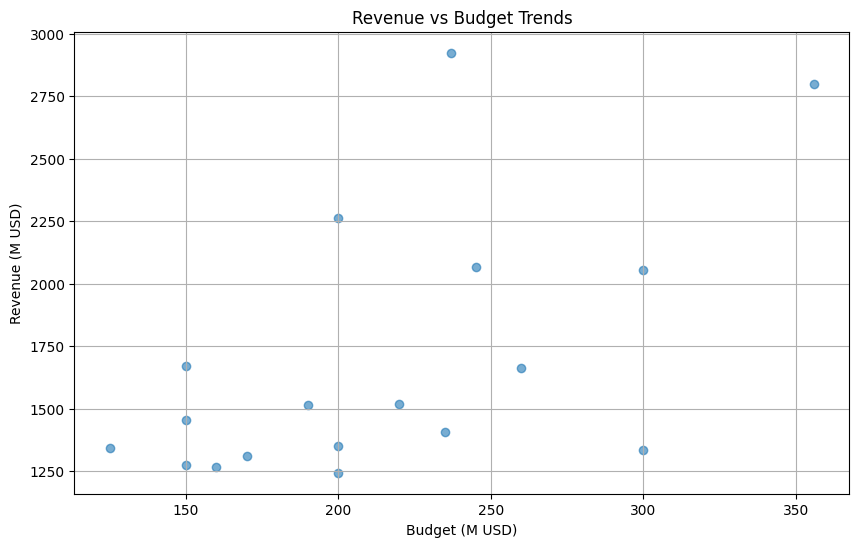

In [91]:

plt.figure(figsize=(10,6))
plt.scatter(wanted_data['budget_musd_num'], wanted_data['revenue_musd_num'], alpha=0.6)
plt.xlabel('Budget (M USD)')
plt.ylabel('Revenue (M USD)')
plt.title('Revenue vs Budget Trends')
plt.grid(True)
plt.show()


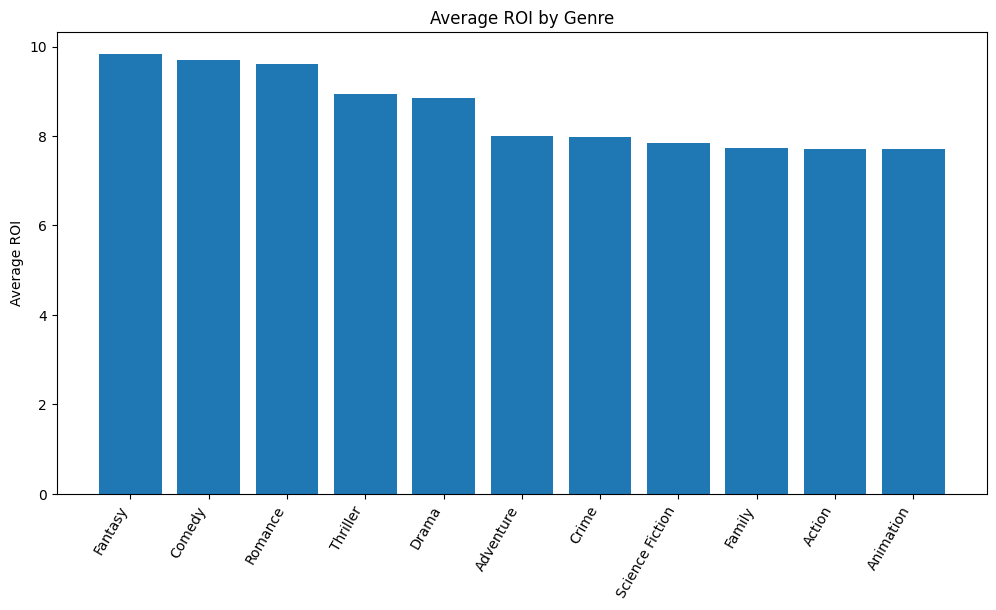

In [92]:

wanted_data['genre_list'] = wanted_data['genres'].apply(lambda x: x.split("|") if isinstance(x, str) else [])

genre_roi = wanted_data.explode('genre_list')

avg_roi = genre_roi.groupby('genre_list')['roi'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
plt.bar(avg_roi.index, avg_roi.values)
plt.xticks(rotation=60, ha='right')
plt.ylabel('Average ROI')
plt.title('Average ROI by Genre')
plt.show()


In [93]:
wanted_data['vote_average']

0     8
1     7
2     7
3     8
4     7
5     6
6     7
7     7
8     7
9     7
10    7
11    8
12    6
13    7
14    6
15    7
16    6
17    7
Name: vote_average, dtype: int64

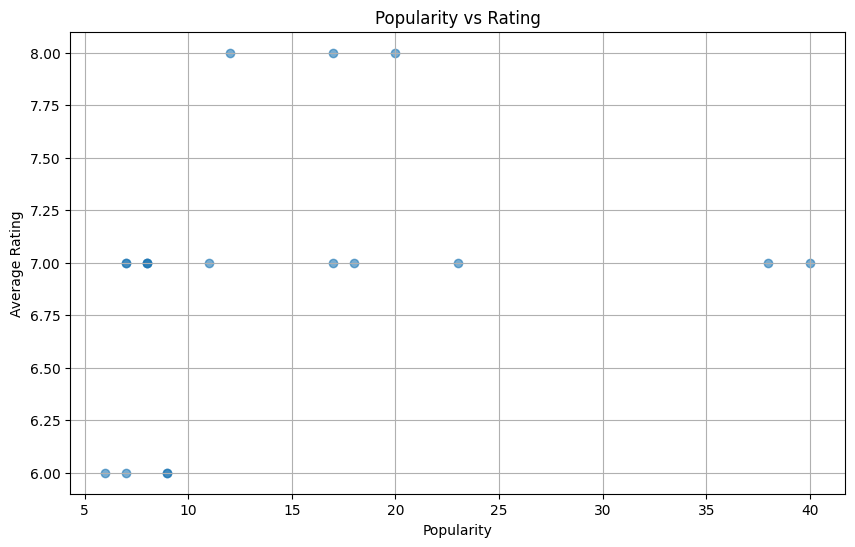

In [94]:
plt.figure(figsize=(10,6))
plt.scatter(wanted_data['popularity'], wanted_data['vote_average'], alpha=0.6)
plt.xlabel('Popularity')
plt.ylabel('Average Rating')
plt.title('Popularity vs Rating')
plt.grid(True)
plt.show()


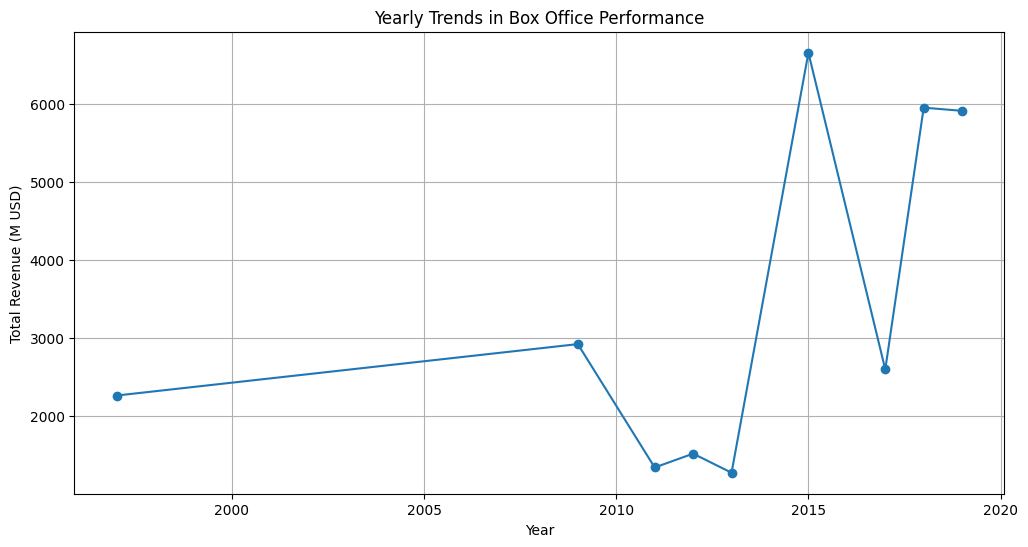

In [95]:
# Convert release_date to datetime if not already
wanted_data['year'] = wanted_data['release_date'].dt.year

yearly_revenue = wanted_data.groupby('year')['revenue_musd_num'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.plot(yearly_revenue['year'], yearly_revenue['revenue_musd_num'], marker='o')
plt.xlabel('Year')
plt.ylabel('Total Revenue (M USD)')
plt.title('Yearly Trends in Box Office Performance')
plt.grid(True)
plt.show()


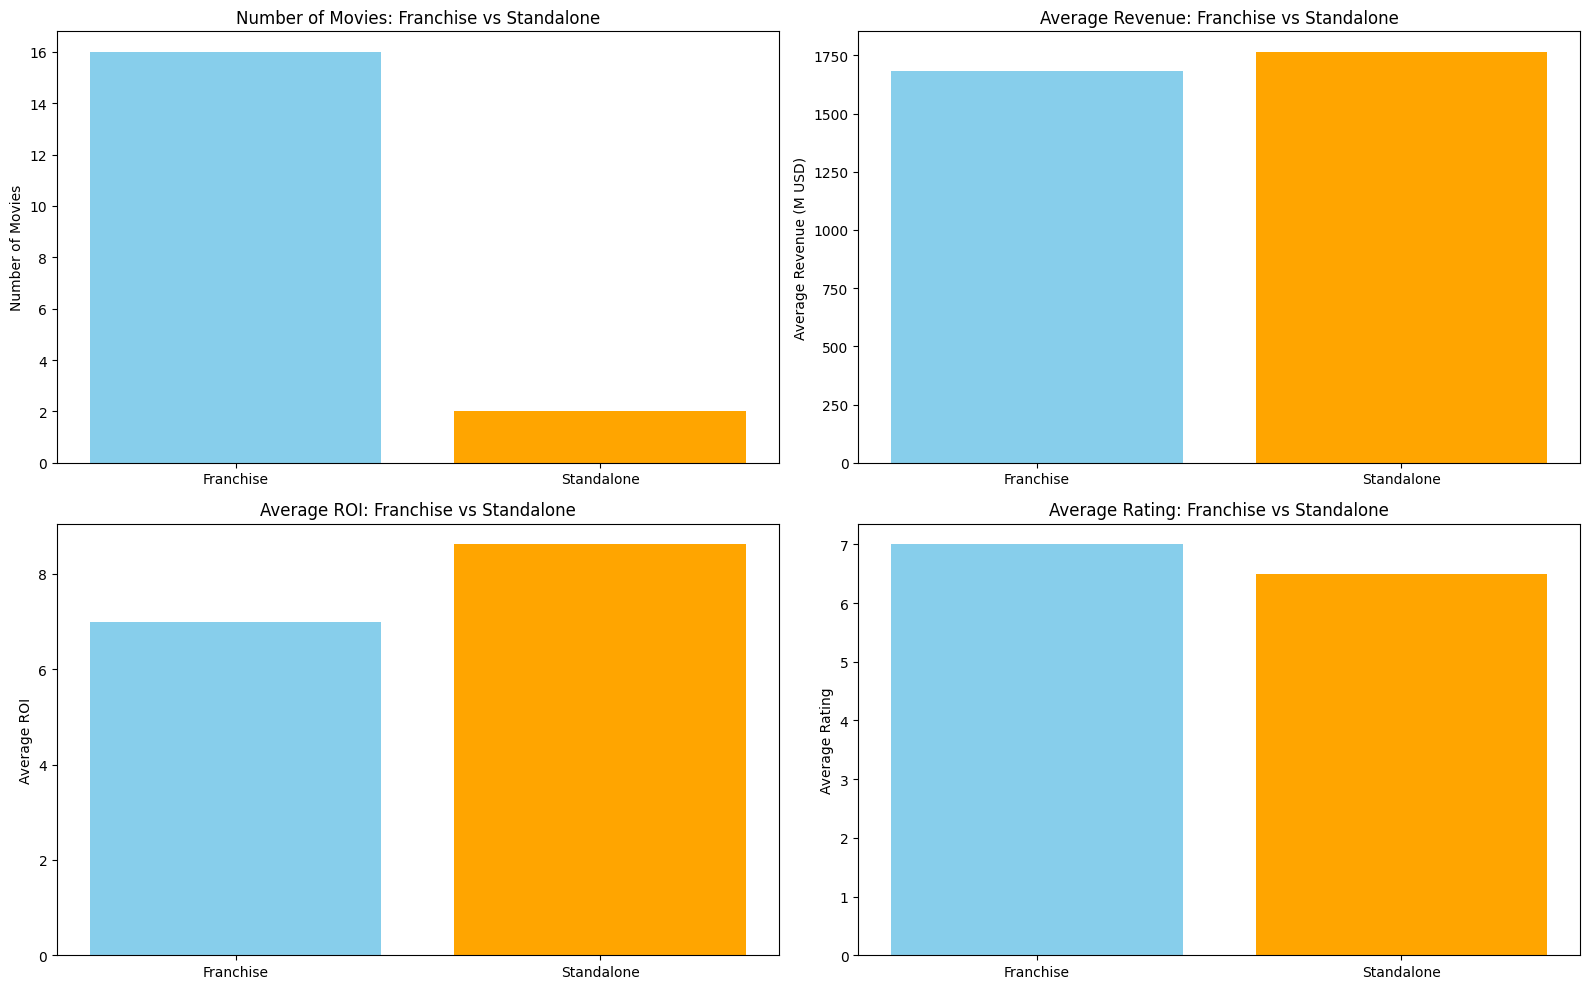

In [96]:
# Label movies as Franchise or Standalone
wanted_data['movie_type'] = wanted_data['belongs_to_collection'].apply(
    lambda x: 'Franchise' if pd.notna(x) else 'Standalone'
)

# Calculate metrics
num_movies = wanted_data['movie_type'].value_counts()
avg_revenue = wanted_data.groupby('movie_type')['revenue_musd_num'].mean()
wanted_data['ROI'] = (wanted_data['revenue_musd_num'] - wanted_data['budget_musd_num']) / wanted_data['budget_musd_num']
avg_roi = wanted_data.groupby('movie_type')['ROI'].mean()
avg_rating = wanted_data.groupby('movie_type')['vote_average'].mean()

# Ensure Franchise is first, Standalone second
num_movies = num_movies.loc[['Franchise','Standalone']]
avg_revenue = avg_revenue.loc[['Franchise','Standalone']]
avg_roi = avg_roi.loc[['Franchise','Standalone']]
avg_rating = avg_rating.loc[['Franchise','Standalone']]

# Plotting
plt.figure(figsize=(16,10))

# 1. Number of Movies
plt.subplot(2,2,1)
plt.bar(num_movies.index, num_movies.values, color=['skyblue','orange'])
plt.ylabel('Number of Movies')
plt.title('Number of Movies: Franchise vs Standalone')

# 2. Average Revenue
plt.subplot(2,2,2)
plt.bar(avg_revenue.index, avg_revenue.values, color=['skyblue','orange'])
plt.ylabel('Average Revenue (M USD)')
plt.title('Average Revenue: Franchise vs Standalone')

# 3. Average ROI
plt.subplot(2,2,3)
plt.bar(avg_roi.index, avg_roi.values, color=['skyblue','orange'])
plt.ylabel('Average ROI')
plt.title('Average ROI: Franchise vs Standalone')

# 4. Average Rating
plt.subplot(2,2,4)
plt.bar(avg_rating.index, avg_rating.values, color=['skyblue','orange'])
plt.ylabel('Average Rating')
plt.title('Average Rating: Franchise vs Standalone')

plt.tight_layout()
plt.show()
